In [23]:
from functools import partial

from sqlalchemy import Column, Table, create_engine, Integer, MetaData, Text, Index, insert, func
from sqlalchemy.event import listen
from sqlalchemy.orm import declarative_base

from geoalchemy2 import Geometry, WKTElement
from geoalchemy2 import load_spatialite
import os
import numpy as np
from shapely.geometry import Polygon as ShapelyPolygon
from shapely import wkb, wkt
import numpy as np
from shapely.affinity import translate
from shapely.affinity import scale
import random
from tqdm import tqdm
import shapely.plotting


# Define models

In [2]:
metadata = MetaData()
Base = declarative_base(metadata=metadata)
class Polygon(Base):
    __tablename__ = "polygons"
    id = Column(Integer, primary_key=True)
    geom = Column(Geometry(srid=4326, geometry_type="POLYGON"))
    image_id = Column(Integer)

In [3]:
def generate_random_polygon(max_area=10):
    num_points = random.randint(10, 20)  # Polygons need at least 3 points

    # Generate points in polar coordinates
    radii = np.sqrt(np.random.uniform(0, 1, num_points))  # Square root ensures uniform distribution
    angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)

    # Convert polar coordinates to Cartesian coordinates
    points = [(r * np.cos(a), r * np.sin(a)) for r, a in zip(radii, angles)]

    # Sort points to form a simple polygon
    sorted_points = sorted(points, key=lambda p: np.arctan2(p[1], p[0]))

    # Create a Polygon and scale its area
    polygon = ShapelyPolygon(sorted_points)

    # Calculate scaling factor
    current_area = polygon.area
    if current_area > 0:
        scaling_factor = np.sqrt(max_area / current_area)
        scaled_points = [(x * scaling_factor, y * scaling_factor) for x, y in sorted_points]
        polygon = ShapelyPolygon(scaled_points)


    translation_x = random.uniform(0, 50)
    translation_y = random.uniform(0, 50)
    polygon = translate(polygon, xoff=translation_x, yoff=translation_y)

    return polygon

In [4]:
def insert_n_polygons(n_polygons, batch_size, connection, image_ids: list):
    polygons_to_insert = []

    for _ in tqdm(range(n_polygons)):
        polygon = generate_random_polygon()
        wkb = wkb.dumps(polygon)
        image_id = int(np.random.choice(image_ids))
        polygons_to_insert.append({"geom": WKTElement(wkt), "image_id": image_id})
        
        
        if len(polygons_to_insert) == batch_size:
            stmt = insert(Polygon).values(polygons_to_insert)
            connection.execute(stmt)
            # connection.execute("INSERT INTO polygons (geom, class_id) VALUES (GeomFromText(?, 4326), ?);", polygons)

# Initialize Database

In [5]:
os.environ['SPATIALITE_LIBRARY_PATH'] = '/usr/lib/x86_64-linux-gnu/mod_spatialite.so'

db_connection_url = "sqlite:///db.sqlite"
engine = create_engine(db_connection_url, echo=True)
load_spatialite_wgs84 = partial(load_spatialite, init_mode="WGS84")
listen(engine, "connect", load_spatialite_wgs84)
conn = engine.connect()

metadata.drop_all(conn, checkfirst=True)
metadata.create_all(conn)

2024-09-26 12:01:08,391 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-09-26 12:01:08,392 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("polygons")
2024-09-26 12:01:08,393 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-09-26 12:01:08,394 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("polygons")
2024-09-26 12:01:08,395 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-09-26 12:01:08,397 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("polygons")
2024-09-26 12:01:08,398 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-09-26 12:01:08,399 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("polygons")
2024-09-26 12:01:08,400 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-09-26 12:01:08,401 INFO sqlalchemy.engine.Engine 
CREATE TABLE polygons (
	id INTEGER NOT NULL, 
	geom GEOMETRY, 
	image_id INTEGER, 
	PRIMARY KEY (id)
)


2024-09-26 12:01:08,402 INFO sqlalchemy.engine.Engine [no key 0.00085s] ()
2024-09-26 12:01:08,407 INFO sqlalchemy.engine.Engine SELECT RecoverG

In [6]:
image_ids = np.arange(5)
insert_n_polygons(5, 5, conn, image_ids)

  0%|          | 0/5 [00:00<?, ?it/s]

2024-09-26 12:01:16,075 INFO sqlalchemy.engine.Engine INSERT INTO polygons (geom, image_id) VALUES (GeomFromEWKT(?), ?), (GeomFromEWKT(?), ?), (GeomFromEWKT(?), ?), (GeomFromEWKT(?), ?), (GeomFromEWKT(?), ?)
2024-09-26 12:01:16,075 INFO sqlalchemy.engine.Engine [no key 0.00048s] ('SRID=4326;POLYGON((27.8509585143207516 42.9412974135204948, 27.3037695464696029 42.1772255115394685, 28.4298779279636946 42.4207257867897525, 28.2178 ... (541 characters truncated) ... 7095 44.7561420717759617, 27.4965613325925844 44.0182742282461135, 26.6626332546868952 43.5568324372633384, 27.8509585143207516 42.9412974135204948))', 0, 'SRID=4326;POLYGON((8.4941634218920719 18.7547265569269612, 9.8379642528503393 18.6030190658955803, 9.7286726866659183 17.8011008539759672, 10.0877084 ... (452 characters truncated) ... 4267939 21.3960616115115592, 9.9950838572930216 19.6600420531747524, 8.2658306490798807 19.6483016950457881, 8.4941634218920719 18.7547265569269612))', 0, 'SRID=4326;POLYGON((21.94471651064351

100%|██████████| 5/5 [00:00<00:00, 302.29it/s]


In [7]:

conn.commit()
conn.close()

2024-09-26 12:01:18,329 INFO sqlalchemy.engine.Engine COMMIT


In [22]:
polygons_table = Table('polygons', metadata, autoload=True, autoload_with=engine)

with engine.connect() as conn:
    result = conn.execute(polygons_table.select())
    
    ps = result.fetchall()
    
for polygon in ps:
    print(wkb.loads(polygon[1].data))

2024-09-26 12:20:14,622 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-09-26 12:20:14,624 INFO sqlalchemy.engine.Engine SELECT polygons.id, AsEWKB(polygons.geom) AS geom, polygons.image_id 
FROM polygons
2024-09-26 12:20:14,625 INFO sqlalchemy.engine.Engine [cached since 441.9s ago] ()
2024-09-26 12:20:14,627 INFO sqlalchemy.engine.Engine ROLLBACK
POLYGON ((27.85095851432075 42.941297413520495, 27.303769546469603 42.17722551153947, 28.429877927963695 42.42072578678975, 28.217863859519028 41.1362374778723, 28.898778286083893 40.707708016138305, 29.227727515611083 42.65005551968988, 29.902996011378313 41.92259309575784, 30.78296188999347 41.84090645472322, 30.92200106613358 42.52481620231877, 30.886339454223467 43.14991671846463, 31.029997941685917 43.81209260881763, 31.034900335281584 44.65501854520234, 29.984181752683256 44.50150436898478, 29.68160794360101 45.442111194137865, 28.926239453007426 45.260718421143224, 28.757390805986194 43.93359841299797, 27.62251086697971 44.7561420

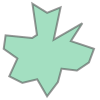

In [28]:
wkb.loads(ps[4][1].data)